**Importing Essential Libraries**


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
import tensorflow as tf
import pickle

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D ,AveragePooling2D, Flatten, Dropout
from keras.layers.core import Dense
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.set()

**Unzipping the Train and Test sets**

In [101]:
os.getcwd()

'/content'

In [0]:
handle_train=zipfile.ZipFile(r'/content/Train.zip')
handle_train.extractall('/content/train')
handle_train.close()
handle_test=zipfile.ZipFile(r'/content/Test.zip')
handle_test.extractall('/content/test')
handle_test.close()

In [0]:
train_images=os.listdir('/content/train/Train/')
test_images = os.listdir('/content/test/Test')

filepath_train = '/content/train/Train/'
filepath_test = '/content/test/Test/' 

In [104]:
df_train = pd.read_csv('/content/train.csv')
df_train.head(10)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
5,6283.jpg,MIDDLE
6,23495.jpg,YOUNG
7,7100.jpg,YOUNG
8,6028.jpg,YOUNG
9,22617.jpg,OLD


In [105]:
sample_submn = pd.read_csv('/content/sample_submission_sDO3m7O.csv')
sample_submn.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


**Reading & Resizing Training and Testing images**

In [0]:

images=[]
labels=[]

for index, row in df_train.iterrows():
  image=cv2.imread(filepath_train+row['ID'])
  image=cv2.resize(image , (64,64))
  images.append(image)
  labels.append(row['Class'])
  #print(row['ID'])


In [0]:
images_test=[]
outputs=[]

for index,row in sample_submn.iterrows():
  image=cv2.imread(filepath_test+row['ID'])
  image=cv2.resize(image , (64,64))
  images_test.append(image) 
  outputs.append(image)

**Displaying couple of images for Sanity check**

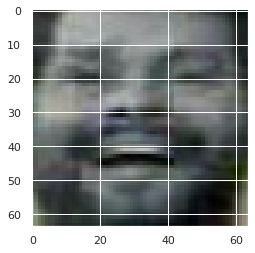

In [108]:
plt.imshow(images[0])

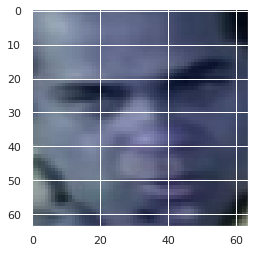

In [109]:
plt.imshow(images[19905])

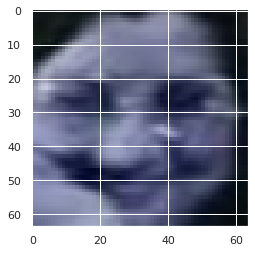

In [110]:
plt.imshow(outputs[0])

Converting into an n-d array and normalizing the image pixels

In [0]:
images = np.array(images, dtype="float") / 255.0
images_test = np.array(images_test, dtype="float") / 255.0
labels = np.array(labels)

**Splitting into train and test set for training**

In [0]:
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.20, random_state=42)

In [113]:
print(type(trainX))
print(trainX.shape)
print(type(trainY))
print(trainY.shape)
print(type(testX))
print(testX.shape)
print(type(testY))
print(testY.shape)

<class 'numpy.ndarray'>
(15924, 64, 64, 3)
<class 'numpy.ndarray'>
(15924,)
<class 'numpy.ndarray'>
(3982, 64, 64, 3)
<class 'numpy.ndarray'>
(3982,)


Binarizing the output categories 

In [0]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [115]:
lb.classes_

array(['MIDDLE', 'OLD', 'YOUNG'], dtype='<U6')

In [116]:
trainY

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

**Model Implementation**

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = "same", activation ='relu', input_shape = (64,64,3)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(84, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(3,activation="softmax"))


In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)       

In [0]:
INIT_LR = 0.025
EPOCHS = 100
BS = 64

opt=SGD(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])

**Image Data Augmentation**

In [0]:
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.1,horizontal_flip=True, fill_mode="nearest")

**Fitting the model onto the training set**

In [121]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY), 
                        steps_per_epoch=len(trainX) // BS,epochs=EPOCHS)

Epoch 1/100
248/248 [==============================] - 32s 131ms/step - loss: 1.0394 - accuracy: 0.5453 - val_loss: 1.0705 - val_accuracy: 0.4927
Epoch 2/100
248/248 [==============================] - 32s 127ms/step - loss: 0.8129 - accuracy: 0.6351 - val_loss: 0.8489 - val_accuracy: 0.6273
Epoch 3/100
248/248 [==============================] - 32s 129ms/step - loss: 0.7791 - accuracy: 0.6519 - val_loss: 0.7469 - val_accuracy: 0.6655
Epoch 4/100
248/248 [==============================] - 32s 129ms/step - loss: 0.7668 - accuracy: 0.6602 - val_loss: 0.7253 - val_accuracy: 0.6768
Epoch 5/100
248/248 [==============================] - 31s 126ms/step - loss: 0.7458 - accuracy: 0.6669 - val_loss: 0.7182 - val_accuracy: 0.6813
Epoch 6/100
248/248 [==============================] - 31s 126ms/step - loss: 0.7358 - accuracy: 0.6725 - val_loss: 0.6683 - val_accuracy: 0.7150
Epoch 7/100
248/248 [==============================] - 31s 125ms/step - loss: 0.7200 - accuracy: 0.6854 - val_loss: 0.7098 -

In [122]:
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

      MIDDLE       0.87      0.89      0.88      2181
         OLD       0.88      0.71      0.79       471
       YOUNG       0.84      0.87      0.85      1330

    accuracy                           0.86      3982
   macro avg       0.87      0.82      0.84      3982
weighted avg       0.86      0.86      0.86      3982



**Loss-Accuracy Tradeoff graph**

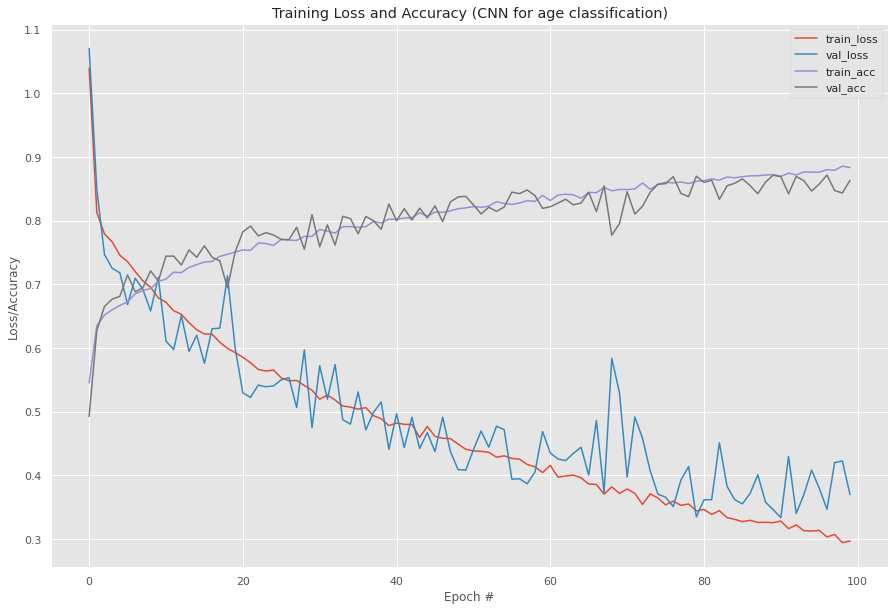

In [123]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS) #setting up x axis
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (CNN for age classification)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**Predicting for test set values**

In [124]:
pred = model.predict(images_test)
pred

array([[5.51453710e-01, 3.38317491e-02, 4.14714545e-01],
       [1.04332095e-04, 3.34534548e-06, 9.99892354e-01],
       [8.87765944e-01, 9.78326704e-03, 1.02450833e-01],
       ...,
       [9.71336663e-01, 1.39194410e-02, 1.47439968e-02],
       [9.85195279e-01, 1.33954082e-02, 1.40937557e-03],
       [1.81941092e-02, 6.92153675e-03, 9.74884391e-01]], dtype=float32)

In [125]:
i = pred.argmax(axis=1)
i

array([0, 2, 0, ..., 0, 0, 2])

In [126]:
#Going for second test example 
i1 = pred.argmax(axis=1)[1]
i1

2

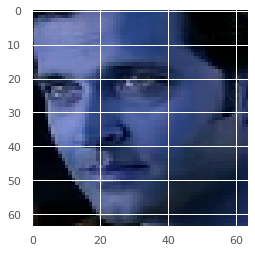

In [127]:
plt.imshow(images_test[1])

In [128]:
vals = np.amax(pred, axis=1)
vals

array([0.5514537 , 0.99989235, 0.88776594, ..., 0.97133666, 0.9851953 ,
       0.9748844 ], dtype=float32)

In [129]:
#going for second test example
val1 = vals[1]
val1

0.99989235

In [130]:
#second test example
perc_val1 = val1*100
perc_val1 = perc_val1.round(2)
perc_val1

99.99

In [0]:
from google.colab.patches import cv2_imshow

In [132]:
label1 = lb.classes_[i1]
label1

'YOUNG'

**Displaying final image again after classification**

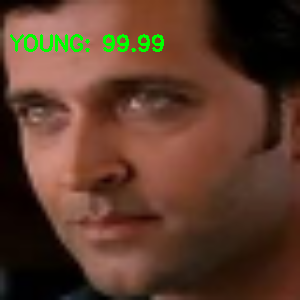

-1

In [133]:
text = label1+": "+str(perc_val1)
#text='.'

outputs[1] = cv2.resize(outputs[1] , (300,300))
cv2.putText(outputs[1], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[1])
cv2.waitKey(0)

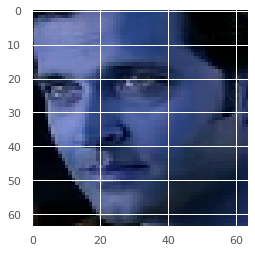

In [134]:
plt.imshow(images_test[1])

In [135]:
output_labels = lb.classes_[i]
output_labels

array(['MIDDLE', 'YOUNG', 'MIDDLE', ..., 'MIDDLE', 'MIDDLE', 'YOUNG'],
      dtype='<U6')

In [136]:
submission = pd.DataFrame({'Class':output_labels,'ID':sample_submn['ID']})
submission

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
...,...,...
6631,MIDDLE,1876.jpg
6632,MIDDLE,14940.jpg
6633,MIDDLE,3638.jpg
6634,MIDDLE,376.jpg


In [0]:
submission.to_csv('submission_agenet.csv',index=False)

In [0]:
from google.colab import files
files.download("submission_agenet.csv")

In [139]:
#Going for fourth test example 
i3 = pred.argmax(axis=1)[3]
i3

0

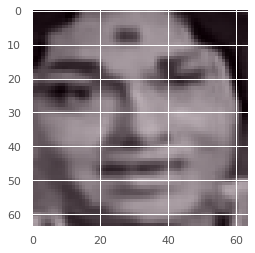

In [140]:
plt.imshow(images_test[3])

In [141]:
val3 = vals[3]
val3

0.9966608

In [142]:
#second test example
perc_val3 = val3*100
perc_val3 = perc_val3.round(2)
perc_val3

99.67

In [143]:
label3 = lb.classes_[i3]
label3

'MIDDLE'

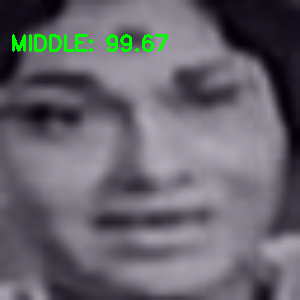

-1

In [144]:
text = label3+": "+str(perc_val3)
#text='.'

outputs[3] = cv2.resize(outputs[3] , (300,300))
cv2.putText(outputs[3], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[3])
cv2.waitKey(0)

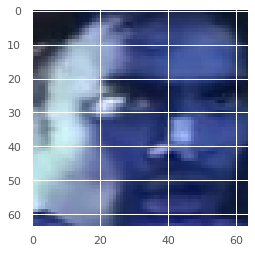

In [145]:
plt.imshow(images[1])

In [146]:
#Going for 6634 test example 
i6631 = pred.argmax(axis=1)[6631]
i6631

0

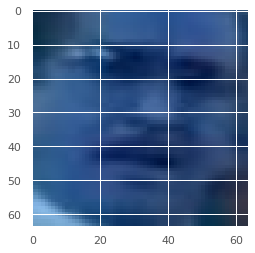

In [147]:
plt.imshow(images_test[6631])

In [148]:
val6631 = vals[6631]
val6631

0.6485496

In [149]:
#second test example
perc_val6631 = val6631*100
perc_val6631 = perc_val6631.round(2)
perc_val6631

64.85

In [150]:
label6631 = lb.classes_[i6631]
label6631

'MIDDLE'

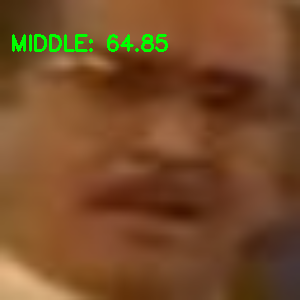

-1

In [151]:
text = label6631+": "+str(perc_val6631)
#text='.'

outputs[6631] = cv2.resize(outputs[6631] , (300,300))
cv2.putText(outputs[6631], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[6631])
cv2.waitKey(0)

In [152]:
sample_submn[sample_submn['ID'] == '2456.jpg']

,Class,ID
3533,MIDDLE,2456.jpg


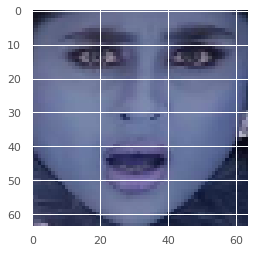

In [153]:
plt.imshow(images_test[3533])

In [154]:
#Going for second test example 
i3533 = pred.argmax(axis=1)[3533]
i3533

2

In [155]:
val3533 = vals[3533]
val3533

0.99398476

In [156]:
perc_val3533 = val3533*100
perc_val3533 = perc_val3533.round(2)
perc_val3533

99.4

In [157]:
label3533 = lb.classes_[i3533]
label3533

'YOUNG'

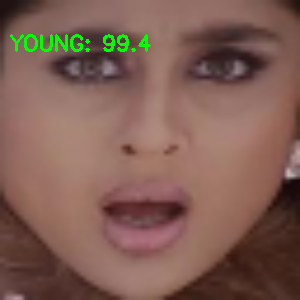

-1

In [158]:
text = label3533+": "+str(perc_val3533)
#text='.'

outputs[3533] = cv2.resize(outputs[3533] , (300,300))
cv2.putText(outputs[3533], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[3533])
cv2.waitKey(0)

**Exporting .h5 and .json files for Deployment in Flask**

In [0]:
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
 #   json_file.write(model_json)

# serialize weights to HDF5
#model.save_weights("model.h5")

In [0]:
#from google.colab import files
#files.download("model.h5")

In [0]:
#from google.colab import files
#files.download("model.json")